# An example running on an IBM quantum computer

## Setting up the quantun computer

In [1]:
import qiskit

In [2]:
from getpass import getpass

In [ ]:
try:
    with open("IBM_token.txt") as file:
        api_token = file.read()
except FileNotFoundError:
    api_token = input("Please enter your IBM API token here, or store it in 'IBM_token.txt'")

In [ ]:
from qiskit import IBMQ
provider = IBMQ.enable_account(api_token)

In [ ]:
provider = IBMQ.get_provider(hub='ibm-q-research', group='plymouth-1', project='qutune')

## Setting up the composer

In [57]:
example_six_bits = [0,0,0,1,0,0]

We will go through how to turn these 7 bits into music first, and then show how to set up the PQCA.

In [11]:
import music21
import musical_scales
import pqca
import qiskit

music21: Certain music21 functions might need the optional package matplotlib;
                  if you run into errors, install it by following the instructions at
                  http://mit.edu/music21/doc/installing/installAdditional.html


`music21` may be showing a warning about potentially needing `matplotlib` - we will not require this functionality.

## From bits to a chord of notes

We will split this bitstring into four parts.
 - Bits 0 and 1 denote the mode
 - Bits 2-5 determine which notes are in the chord

An example mode is "A major", and if our bitstring indicated we should play notes 1, 2, and 3 in this mode then our chord would be "A B C#".

We will be using the `musical_scales` package for easy access to these modes and notes.

In [7]:
from musical_scales import scale

Let's break our bitstring up into the sections we declared above.

In [58]:
def bit_breakdown(six_bits_long):
    """Break our seven bits into two segments."""
    return {
            "scale": six_bits_long[0:2],
            "notes": six_bits_long[2:6]
    }

And here's an example of this breakdown in action:

In [60]:
bit_breakdown(example_six_bits)

{'scale': [0, 0], 'notes': [0, 1, 0, 0]}

As in our tutorial we will use the following 4 doo-wop chords:
 - E major
 - B major
 - C# harmonic minor
 - A major

In [13]:
modes_to_choose_from = [
    ("E", "major"), ("B", "major"), ("C#", "harmonic minor"), ("A", "major")
]
def bits_to_scale_data(mode_bits, modes = modes_to_choose_from):
    def note_mode_pair_to_object(note_mode_pair):
        note, mode = note_mode_pair
        return {"fundamental": note, "mode": mode}
    
    if mode_bits[0]:
        if mode_bits[1]:
            return note_mode_pair_to_object(modes[0])
        return note_mode_pair_to_object(modes[1])
    if mode_bits[1]:
        return note_mode_pair_to_object(modes[2])
    return note_mode_pair_to_object(modes[3])

This is enough information for someone to sit down and work out the chord on a piano. We want this music to be stored as a MIDI file so our computers can play it for us. We will be using the `music21` package to handle MIDI creation.

In [61]:
def chord_from_bits(bits, note_lengths=["quarter","eighth"]):
    breakdown = bit_breakdown(bits)
    scale_data = bits_to_scale_data(breakdown["scale"])
    scale_notes = scale(scale_data["fundamental"], scale_data["mode"])
    list_of_notes = [str(note) for index, note in enumerate(scale_notes[0:1] + scale_notes[2:5])
           if breakdown["notes"][index]]
    this_chord = music21.chord.Chord(list_of_notes)
    this_chord.duration = music21.duration.Duration("half")
    return this_chord

In [62]:
chord_from_bits(example_six_bits)

<music21.chord.Chord C#4>

### (Non-quantum) example bits

Our first demonstration will use a _classical_ bitstream generator. We will replace this with a partitioned quantum cellular automaton later on.

In [63]:
import random

In [64]:
class Bit_Generator:
    def __next__(self):
        return [random.random() > 0.5 for i in range(0,12)]
BG = Bit_Generator()

This just generates 12 bits as a time each time we call `next(BG)`, with each entry in the sequence having a 50/50 chance of being 0 or 1. With our classical bitstream generator we can generate sequences of chords.

In [65]:
chord_sequence = [chord_from_bits(next(BG)) for i in range(0,20)]

A `stream` is how music21 handles a sequence of chords.

In [66]:
instrumentation = music21.instrument.Vibraphone() # Vibraphone

#instrumentation = music21.instrument.instrumentFromMidiProgram(24) # Acoustic Nylon Guitar
#instrumentation = music21.instrument.Harpsichord() # Harpsichord
def stream_from_chords(chords, instrument=instrumentation):
    stream = music21.stream.Stream()
    stream.insert(0, instrument)
    for chord in chords:
        stream.append(chord)
    return stream

That's all the data we need, so write it to a MIDI file.
    

In [67]:
def save_midi(stream, output_midi_file="temp.midi"):
    stream.write("midi",output_midi_file)

In [68]:
save_midi(stream_from_chords(chord_sequence)) # Saves to "temp.midi" by default

To draw the score we'll need access to `ipython`'s `Image` class:

In [69]:
from IPython.display import Image

In [70]:
def show_score(stream):
    return Image(stream.write("lily.png"))

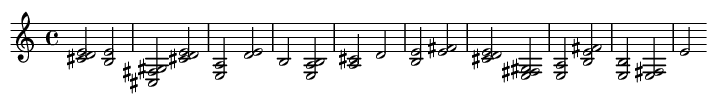

In [71]:
show_score(stream_from_chords(chord_sequence))

# Drawing the states

Many people find it easier to imagine the state of a cellular automaton as a sequence of squares (white for 1, black for 0).
This was discussed a little in the Getting Started tutorial, and we will use similar code here to represent what is going on with our `Bit_Generator`.

In [53]:
import drawSvg
def quilt(list_of_list_of_bits):
    # This code just draws things, understanding it isn't necessary for the tutorial
    if len(list_of_list_of_bits) == 0:
        return
    square_size = 20 # in pixels
    number_of_iterations = len(list_of_list_of_bits)
    number_of_bits = len(list_of_list_of_bits[0])
    drawing = drawSvg.Drawing(square_size*number_of_bits, square_size*number_of_iterations)
    for iteration, list_of_bits in enumerate(list_of_list_of_bits):
        for index, bit in enumerate(list_of_bits):
            colour = '#eeeeee' if bit else '#000000'
            rect = drawSvg.Rectangle(index*square_size,(number_of_iterations-iteration-1)*square_size,square_size,square_size, fill=colour)
            drawing.append(rect)
    return drawing

Let's call on `BG` 20 times, drawing each result as a new row in the quilt.

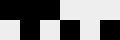

In [72]:
quilt([[0,0,0,1,1,1], [1,0,1,0,1,0]])

# Making it quantum

In [100]:
import pqca

In [101]:
num_qubits = 6
tessellated_line = pqca.tessellation.one_dimensional(num_qubits,2)

In [102]:
print(tessellated_line)

Tessellation(6 qubits as 3 cells, first cell: [0, 1])


With this partition in place we can specify an update circuit that will be applied to each cell of 2 qubits. Here's an example circuit.

In [103]:
import qiskit
two_cell_circuit = qiskit.QuantumCircuit(2)
two_cell_circuit.h(0)
two_cell_circuit.cx(0,1)
two_cell_circuit.draw()

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

In [104]:
update_frame_1 = pqca.UpdateFrame(tessellated_line, qiskit_circuit=two_cell_circuit)

In [105]:
three_cell_circuit = qiskit.QuantumCircuit(3)
three_cell_circuit.h(0)
three_cell_circuit.cz(1,2)
three_cell_circuit.draw()

┌───┐
q_0: ┤ H ├
     └───┘
q_1: ──■──
       │  
q_2: ──■──

In [106]:
update_frame_2 = pqca.UpdateFrame(pqca.tessellation.one_dimensional(num_qubits,3), qiskit_circuit=three_cell_circuit)

An automaton has a starting state and way of updating that state. For our automaton we will need to provide:
 - An initial state
 - A list of update frames
 - A circuit simulator
 

In [107]:
initial_state = [0]*num_qubits
initial_state[0] = 1

That's our initial state done, and we only have one update frame, so let's make the automaton.

In [108]:
def backend(circuit: qiskit.QuantumCircuit):
    """Run the circuit on IBM jakarta."""
    circuit.measure_all()
    results = qiskit.execute(circuit, provider.backend.ibmq_jakarta, shots=1).result()
    if results.success:
        final_state_as_string = list(results.get_counts(circuit).keys())[0]
        return [int(x) for x in final_state_as_string[::-1]]
    raise exceptions.BackendError(results.status)

In [109]:
automaton = pqca.Automaton(initial_state, [update_frame_1, update_frame_2], backend)

An automaton only knows its current state and how to update that state. Here's our starting state:

In [110]:
automaton.state

[1, 0, 0, 0, 0, 0]

But what will it actually do? Well, the full update circuit can be accessed via `automaton.update_circuit`.

In [111]:
automaton.update_circuit.draw()

┌───┐     ┌───┐
q_0: ┤ H ├──■──┤ H ├
     └───┘┌─┴─┐└───┘
q_1: ─────┤ X ├──■──
     ┌───┐└───┘  │  
q_2: ┤ H ├──■────■──
     └───┘┌─┴─┐┌───┐
q_3: ─────┤ X ├┤ H ├
     ┌───┐└───┘└───┘
q_4: ┤ H ├──■────■──
     └───┘┌─┴─┐  │  
q_5: ─────┤ X ├──■──
          └───┘

The automaton will create a circuit that:
 - Initialises the qubits (based on current state)
 - Applies the update_circuit
 - Measures the qubits

The automaton will then update its state with the newly measured results.

## Actually running it

Let's make our PQCA into an iterator that updates and returns its state as a sequence of 6 bits each time it is called for.

In [112]:
class Qubit_Generator:
    def __next__(self):
        return automaton.iterate(1)[0]
QBG = Qubit_Generator()

What does the output look like?

In [113]:
next(QBG)

[1, 0, 1, 1, 0, 0]

Just as with the classical bit generator we can draw a quilt of squares, with each row representing a new state of the automaton.

In [114]:
state_sequence = [next(QBG) for _ in range(24)]

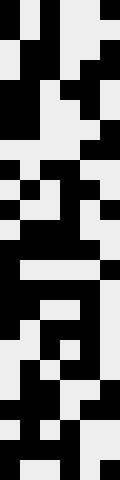

In [115]:
quilt(state_sequence)

Let's use it to make music, just as we did before.

In [119]:
chord_sequence = [chord_from_bits(state) for state in state_sequence]

In [120]:
save_midi(stream_from_chords(chord_sequence), "ibm_pqca.midi")

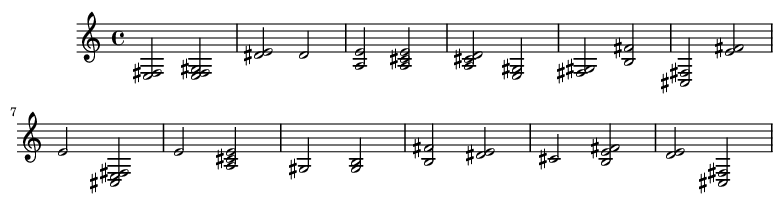

In [121]:
show_score(stream_from_chords(chord_sequence))

If you would rather work with MusicXML than MIDI then you can use the following function to do so, provided you have [MuseScore](https://musescore.org) installed.

In [125]:
stream_from_chords(chord_sequence).write("lily.png", fp="ibm_pqca")

PosixPath('ibm_pqca.png')

In [122]:
def save_musicxml(stream, file="temp.xml"):
    stream.write("musicxml", file)
#save_musicxml(stream_from_chords(chord_sequence)) # requires MuseScore

In [123]:
save_musicxml(stream_from_chords(chord_sequence), "ibm_pqca.xml")